In [ ]:
import sys
sys.path.append('..')
import spark

import jax
import jax.numpy as jnp
import numpy as np
import gymnasium as gym
import ale_py
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt

gym.register_envs(ale_py)

In [2]:
# Utility function to execute brain efficiently.
@partial(jax.jit, static_argnames='steps')
def run_model(graph, state, steps, **inputs):
	# Merge model
	model = spark.merge(graph, state)
	# Run model
	for _ in range(steps):
		out = model(**inputs)
	# Get new state
	_, state = spark.split((model))
	return out, state

# Utility function to retrieve data from the model.
@partial(jax.jit, static_argnames='steps')
def run_model_and_record(graph, state, steps, **inputs):
	# Merge model
	model = spark.merge(graph, state)
	# Prepare spike container
	spikes = {k: [] for k in model.get_spikes_from_cache().keys()}
	for _ in range(steps):
		# Run model
		out = model(**inputs)
		# Get spikes
		for k, v in model.get_spikes_from_cache().items():
			spikes[k].append(v)
	# Get new state
	_, state = spark.split((model))
	# Process spikes
	process_spikes = []
	for s in range(steps):
		process_spikes.append(
			jnp.concatenate([spikes[k][s].value.reshape(-1) for k in spikes.keys()])
		)
	return out, state, process_spikes

# Utility function to preprocess information from the environment.
def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

# Reward function.
def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

In [3]:
env_name =  'CartPole-v1'
env = gym.make(env_name)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

STEPS_10MS = 100
TRAIN_EPOCHES = 500
TEST_EPOCHES = 10

In [4]:
# Load the Brain.
brain_config = spark.nn.BrainConfig.from_file('example_ab_model.scfg')
# Initialize the Brain.
brain = spark.nn.Brain(config=brain_config)
# Build the Brain.
brain(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))
# Split brain into the graph and the state
graph, state = spark.split((brain))
# Compitle runtime fn. Depending on the number of steps this may take a little bit of time.
run_model(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
run_model_and_record(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)));

In [27]:
def dummy_map(path: tuple[jax.tree_util.DictKey | jax.tree_util.GetAttrKey], leaf: jax.Array):
	leaf_path = '.'.join([p.key for p in path if hasattr(p, 'key')])
	# Print the path of the leaf
	if leaf_path.split('.')[-1] == 'dt':
		print(leaf_path, leaf.dtype)
	return None

sharding_rules = jax.tree_util.tree_map_with_path(dummy_map, state)

In [5]:
# A fresh brain
graph, state = spark.split((brain))
# A fresh environment
next_obs, _ = env.reset(seed=42)
# Some classic training loop.
reward = 0
for i in tqdm(range(TRAIN_EPOCHES)):
	terminated = False
	while not terminated:
		next_obs = process_obs(next_obs)
		prev_obs = next_obs
		# Model logic
		out, state = run_model(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		# Environment logic.
		next_action = int(np.argmax(out['action'].value))
		next_obs, _, terminated, truncated, info = env.step(next_action)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	# Reset environment
	next_obs, _ = env.reset()
	# Flush model. Pass a zero vector for 10 ms to let the model "cooldown" a little bit.
	_, state = run_model(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))

100%|██████████| 500/500 [00:48<00:00, 10.27it/s]


100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


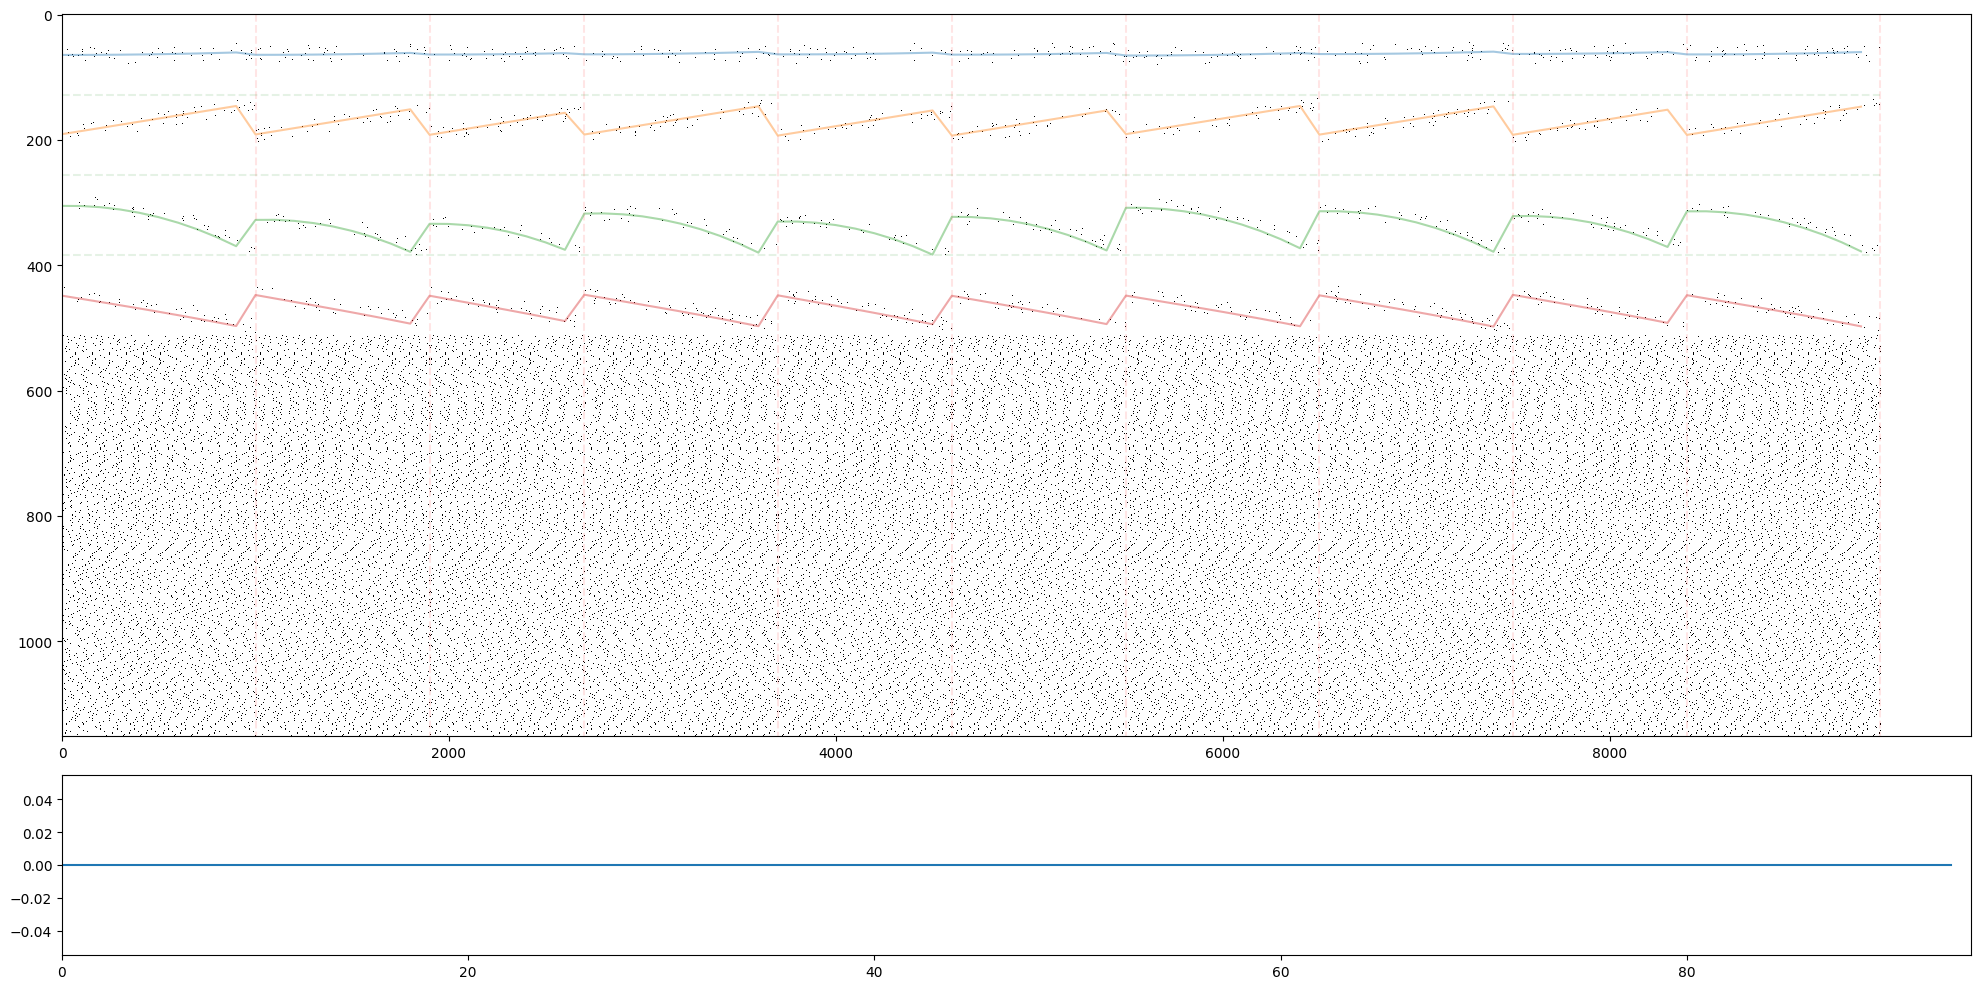

In [ ]:
spikes = []
breaks = []
actions = []
env_obs = []
reward = 0
# A fresh environment
next_obs, _ = env.reset(seed=42+1)
env_steps = 0
for i in tqdm(range(TEST_EPOCHES)):
	terminated = False
	while not terminated:
		next_obs = process_obs(next_obs)
		env_obs.append(next_obs)
		prev_obs = next_obs
		# Model logic
		out, state, model_spikes = run_model_and_record(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		spikes += model_spikes
		# Environment logic.
		next_action = int(np.argmax(out['action'].value))
		next_obs, _, terminated, truncated, info = env.step(next_action)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		actions.append(next_action)
		env_steps += 1
	# Reset environment
	next_obs, _ = env.reset()
	breaks.append(STEPS_10MS*env_steps)
	# Flush model. Pass a zero vector for 10 ms to let the model "cooldown" a little bit.
	_, state = run_model(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))

fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,spikes.shape[1]-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[0]+64, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[1]+64+128, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[2]+64+256, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(np.linspace(0,breaks[-1], len(actions)), actions)
ax[0].set_xlim(0, breaks[-1])
ax[1].set_xlim(0, breaks[-1])
plt.tight_layout()
plt.show()

100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


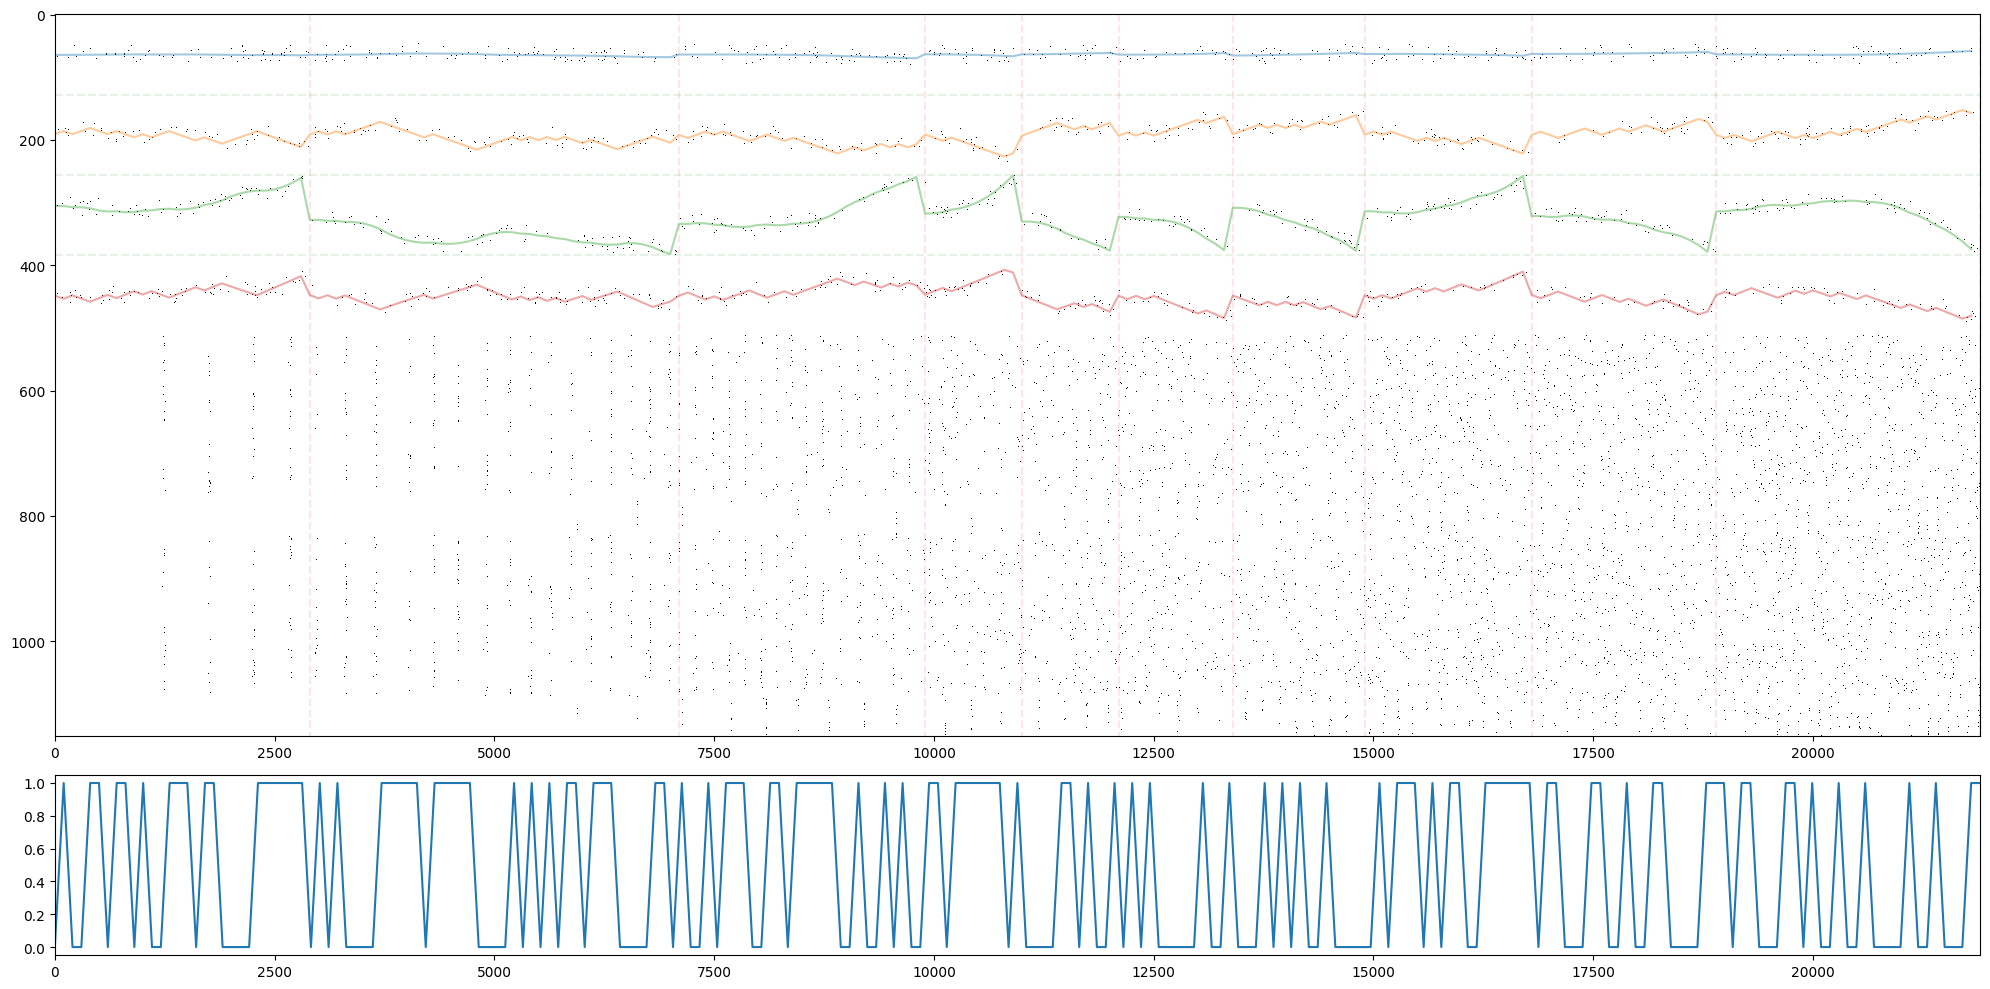

In [38]:
spikes = []
breaks = []
actions = []
env_obs = []
reward = 0
# A fresh brain
graph, state = spark.split((brain))
# A fresh environment
next_obs, _ = env.reset(seed=42+1)
env_steps = 0
for i in tqdm(range(TEST_EPOCHES)):
	terminated = False
	while not terminated:
		next_obs = process_obs(next_obs)
		env_obs.append(next_obs)
		prev_obs = next_obs
		# Model logic
		out, state, model_spikes = run_model_and_record(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		spikes += model_spikes
		# Environment logic.
		next_action = np.random.rand() < 0.5
		next_obs, _, terminated, truncated, info = env.step(next_action)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		actions.append(next_action)
		env_steps += 1
	# Reset environment
	next_obs, _ = env.reset()
	breaks.append(STEPS_10MS*env_steps)
	# Flush model. Pass a zero vector for 10 ms to let the model "cooldown" a little bit.
	_, state = run_model(graph, state, steps=STEPS_10MS, drive=spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))

fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,spikes.shape[1]-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[0]+64, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[1]+64+128, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[2]+64+256, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(np.linspace(0, breaks[-1], len(actions)), actions)
ax[0].set_xlim(0, breaks[-1])
ax[1].set_xlim(0, breaks[-1])
plt.tight_layout()
plt.show()